https://github.com/fengdu78/machine_learning_beginner/tree/master/PyTorch_beginner

#### 训练一个分类器

# 关于数据
* 对于图像,有诸如Pillow,OpenCV包等非常实用
* 对于音频,有诸如scipy和librosa包
* 对于文本,可以用原始Python和Cython来加载,或者使用NLTK和SpaCy 对于视觉,我们创建了一个torchvision包,包含常见数据集的数据加载,比如Imagenet,CIFAR10,MNIST等,和图像转换器,也就是torchvision.datasets和torch.utils.data.DataLoader。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# 1.加载和归一化CIFAR0
# torchvision的输出是0,1的PILImage图像，把它转换为归一化范围为-1,1的张量
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='../../dataset/', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='../../dataset/', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████▉| 170483712/170498071 [09:38<00:00, 214568.62it/s]

Extracting ../../dataset/cifar-10-python.tar.gz to ../../dataset/
Files already downloaded and verified


170500096it [09:50, 214568.62it/s]                                                                                     

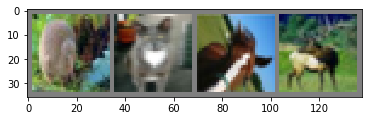

 bird   cat horse  deer


In [5]:
# 展示一些有趣的训练图像
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images,labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [6]:
# 定义一个卷积神经网络
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [7]:
# 定义损失函数和优化器
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [8]:
# 训练网络
# 只需在数据迭代器上循环，把数据输入给网络，并优化
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.244
[1,  4000] loss: 1.854
[1,  6000] loss: 1.668
[1,  8000] loss: 1.582
[1, 10000] loss: 1.517
[1, 12000] loss: 1.467
[2,  2000] loss: 1.401
[2,  4000] loss: 1.374
[2,  6000] loss: 1.342
[2,  8000] loss: 1.308
[2, 10000] loss: 1.292
[2, 12000] loss: 1.259
Finished Training


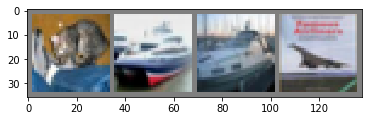

GroundTruth:    cat  ship  ship plane


In [9]:
# 在测试集上测试网络
# 第一步，显示测试集中的图片一遍熟悉图片内容
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
outputs = net(images)

In [11]:
# 输出是10个标签的概率。一个类别的概率越大,神经网络越认为他是这个类别。所以让我们得到最高概率的标签。

In [15]:
_,predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

Predicted:   ship plane plane plane


In [16]:
# 接下来让我们看看网络在整个测试集上的结果如何
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


结果看起来好于偶然，偶然的正确率为10%,似乎网络学习到了一些东西。

那在什么类上预测较好，什么类预测结果不好呢？

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 83 %
Accuracy of  bird : 45 %
Accuracy of   cat : 30 %
Accuracy of  deer : 50 %
Accuracy of   dog : 53 %
Accuracy of  frog : 67 %
Accuracy of horse : 59 %
Accuracy of  ship : 61 %
Accuracy of truck : 47 %


#### 在GPU上训练

In [18]:
# 你是如何把一个Tensor转换GPU上,你就如何把一个神经网络移动到GPU上训练。这个操作会递归遍历有所模块,并将其参数和缓冲区转换为CUDA张量。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
#假设我们有一台CUDA的机器，这个操作将显示CUDA设备。
print(device)

cuda:0


In [19]:
# 接下来假设我们有一台CUDA的机器，然后这些方法将递归遍历所有模块并将其参数和缓冲区转换为CUDA张量：
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

##### 请记住，你也必须在每一步中把你的输入和目标值转换到GPU上:

In [20]:
inputs, labels = inputs.to(device), labels.to(device)

In [21]:
# 为什么我们没注意到GPU的速度提升很多?那是因为网络非常的小。